### This notebook will perform a Time Series Analysis of Eve pvp data using ARIMA modeling.

This analysis will attempt to draw meaningful conclusions from the Beeitnam war PVP data provided on the r/eve subreddit by u/Normann_Tivianne. It's clear from the numbers posted that since the siege of 3-D began, Imperium participation is rising, while PAPI participation is falling. But what (if anything) does the past and current data predict about future participation? Using time series forecasting techniques, we can answer that question.

### Importing and prepping the data

In [2]:
import os
import pandas as pd

pwd = os.getcwd()

path = pwd + "/raw_data/"

evedata_df = pd.read_csv(path + 'evedata.csv', parse_dates=['date'])

evedata_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74 entries, 0 to 73
Data columns (total 25 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   date              74 non-null     datetime64[ns]
 1   gsf               74 non-null     int64         
 2   init              74 non-null     int64         
 3   ph                74 non-null     int64         
 4   test              74 non-null     int64         
 5   brave             74 non-null     int64         
 6   nc                74 non-null     int64         
 7   eve chars         74 non-null     int64         
 8   imperium          74 non-null     int64         
 9   log_imperium      74 non-null     float64       
 10  legacy            74 non-null     int64         
 11  log_legacy        74 non-null     float64       
 12  panfam            74 non-null     int64         
 13  log_panfam        74 non-null     float64       
 14  papi_total        74 non-nul

In [3]:
evedata_df

,date,gsf,init,ph,test,brave,nc,eve chars,imperium,log_imperium,...,other papi,log_otherpapi,fraternity,fire,slicy,eve kms,pl,wh space,imperium wo caps,papi wo caps
0,2020-01-06,2268,703,1505,1284,323,528,29118,4180,3.621176,...,2646,3.422590,1628,801,217,100760,279,4501,3874,7374
1,2020-01-13,2242,714,1631,1138,385,525,29002,4137,3.616686,...,2311,3.363800,1333,772,206,101662,201,4881,3886,6958
2,2020-01-20,2223,707,1715,1263,403,648,29193,4134,3.616370,...,2547,3.406029,1568,802,177,102620,208,4910,3848,7493
3,2020-01-27,1583,536,1445,852,378,551,25237,3284,3.516403,...,2517,3.400883,1664,715,138,89349,178,4156,3078,6639
4,2020-02-03,2317,646,1799,1050,381,677,28923,4160,3.619093,...,3066,3.486572,2090,807,169,101864,243,4466,3935,7842
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69,2021-05-03,2904,755,1790,1271,591,472,30761,4440,3.647383,...,3142,3.497206,2009,873,260,107077,193,4671,4187,8666
70,2021-05-10,2945,709,1765,1231,620,431,30758,4405,3.643946,...,3110,3.492760,2010,893,207,100905,214,4623,3962,8762
71,2021-05-17,3110,707,1758,1258,651,400,29539,4569,3.659821,...,2845,3.454082,1832,849,164,102675,202,4748,4135,8345
72,2021-05-24,2804,660,1510,1019,571,322,28182,4148,3.617839,...,2882,3.459694,1852,853,177,94554,152,4738,3880,7562


In [17]:
imp_df = evedata_df[["date", "imperium"]]
#imp_df.set_index('date')
legacy_df = evedata_df[["date", "legacy"]]
panfam_df = evedata_df[["date", "panfam"]]
papi_df = evedata_df[["date", "papi_total"]]
impsub_df = evedata_df[["date", "imperium wo caps"]]
papisub_df = evedata_df[["date", "papi wo caps"]]


In [11]:
imp_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74 entries, 0 to 73
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   date      74 non-null     datetime64[ns]
 1   imperium  74 non-null     int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 1.3 KB


In [12]:
imp_df.set_index('date')

,imperium
date,
2020-01-06,4180
2020-01-13,4137
2020-01-20,4134
2020-01-27,3284
2020-02-03,4160
...,...
2021-05-03,4440
2021-05-10,4405
2021-05-17,4569


### Visualizing the data

In [68]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [ ]:
""" imp_df.plot(x = 'date', y = 'imperium', title = "Imperium PVP Participaton", figsize=(20, 10))
plt.axvline("2020-03-16", color="red", linestyle="--")
plt.text("2020-03-20",6500,'North',rotation=90)
plt.axvline("2020-07-01", color="red", linestyle="--")
plt.text("2020-07-04",6500,'War',rotation=90)
plt.axvline("2020-10-06", color="red", linestyle="--")
plt.text("2020-10-10",6500,'FWST',rotation=90)
plt.axvline("2020-12-30", color="red", linestyle="--")
plt.text("2021-01-04",6500,'M2',rotation=90)
plt.axvline("2021-04-26", color="red", linestyle="--")
plt.text("2021-04-30",6500,'Siege',rotation=90) """

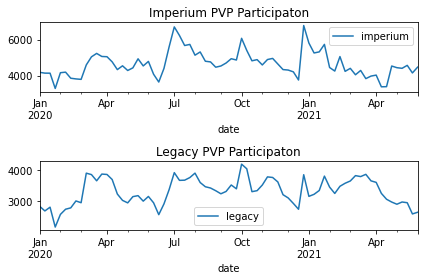

In [66]:
fig, axes = plt.subplots(2)

imp_df.plot(x = 'date', y = 'imperium', title = "Imperium PVP Participaton", ax=axes[0])
legacy_df.plot(x = 'date', y = 'legacy', title = "Legacy PVP Participaton", ax=axes[1])

plt.tight_layout()

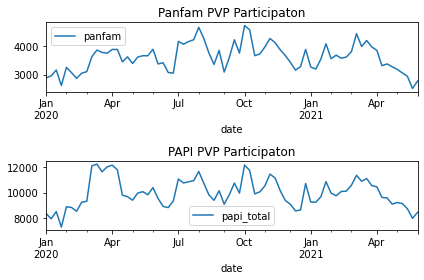

In [67]:
fig, axes = plt.subplots(2)

panfam_df.plot(x = 'date', y = 'panfam', title = "Panfam PVP Participaton", ax=axes[0])
papi_df.plot(x = 'date', y = 'papi_total', title = "PAPI PVP Participaton", ax=axes[1])

plt.tight_layout()

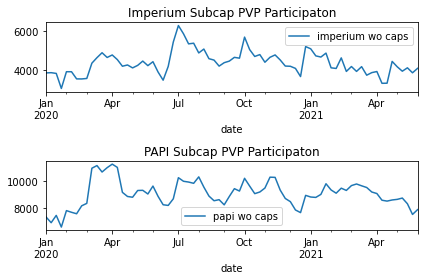

In [62]:
fig, axes = plt.subplots(2)

impsub_df.plot(x = 'date', y = 'imperium wo caps', title = "Imperium Subcap PVP Participaton", ax=axes[0])
papisub_df.plot(x = 'date', y = 'papi wo caps', title = "PAPI Subcap PVP Participaton", ax=axes[1])

plt.tight_layout()

### Augmented Dickey-Fuller test for stationarity:

In [69]:
result = adfuller(imp_df['imperium'])
print('ADF Statistic: {}'.format(result[0]))
print('p-value: {}'.format(result[1]))
print('Critical Values:')
for key, value in result[4].items():
    print('\t{}: {}'.format(key, value))

ADF Statistic: -4.096921694171093
p-value: 0.000979934217847856
Critical Values:
	1%: -3.5232835753964475
	5%: -2.902030597326081
	10%: -2.5883710883843123


In [76]:
for column in evedata_df[['imperium', 'legacy', 'panfam', 'papi_total', 'imperium wo caps', 'papi wo caps']]:
    result = adfuller(evedata_df[column])
    print("\n",column, 'ADF Results:')
    print('ADF Statistic: {}'.format(result[0]))
    print('p-value: {}'.format(result[1]))
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t{}: {}'.format(key, value))


 imperium ADF Results:
ADF Statistic: -4.096921694171093
p-value: 0.000979934217847856
Critical Values:
	1%: -3.5232835753964475
	5%: -2.902030597326081
	10%: -2.5883710883843123

 legacy ADF Results:
ADF Statistic: -3.2935204091578894
p-value: 0.015170608545654071
Critical Values:
	1%: -3.5232835753964475
	5%: -2.902030597326081
	10%: -2.5883710883843123

 panfam ADF Results:
ADF Statistic: -3.6836395092265293
p-value: 0.004349253688484767
Critical Values:
	1%: -3.5232835753964475
	5%: -2.902030597326081
	10%: -2.5883710883843123

 papi_total ADF Results:
ADF Statistic: -3.500060313614315
p-value: 0.007985545215232167
Critical Values:
	1%: -3.5232835753964475
	5%: -2.902030597326081
	10%: -2.5883710883843123

 imperium wo caps ADF Results:
ADF Statistic: -3.5737068856509846
p-value: 0.006284054656371292
Critical Values:
	1%: -3.5232835753964475
	5%: -2.902030597326081
	10%: -2.5883710883843123

 papi wo caps ADF Results:
ADF Statistic: -3.56246388251624
p-value: 0.00652054224382692
C

### All data sets are stationary.